In [40]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('/content/Churn_Modelling.csv')

In [3]:
df.head(2)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


In [4]:
df.shape

(10000, 14)

##Data Analysis

Customer ID, Row Number and Surname are not required during prediction.

In [6]:
df.drop(['CustomerId', 'RowNumber','Surname'], axis = 1, inplace=True)

KeyError: ignored

In [7]:
df.nunique()

CreditScore         460
Geography             3
Gender                2
Age                  70
Tenure               11
Balance            6382
NumOfProducts         4
HasCrCard             2
IsActiveMember        2
EstimatedSalary    9999
Exited                2
dtype: int64

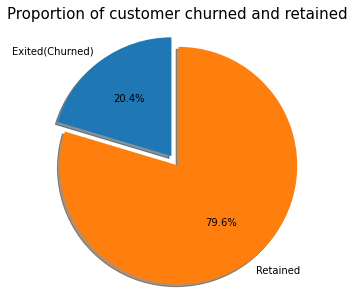

In [11]:
labels = 'Exited(Churned)', 'Retained'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(5, 5))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 15)
plt.show()

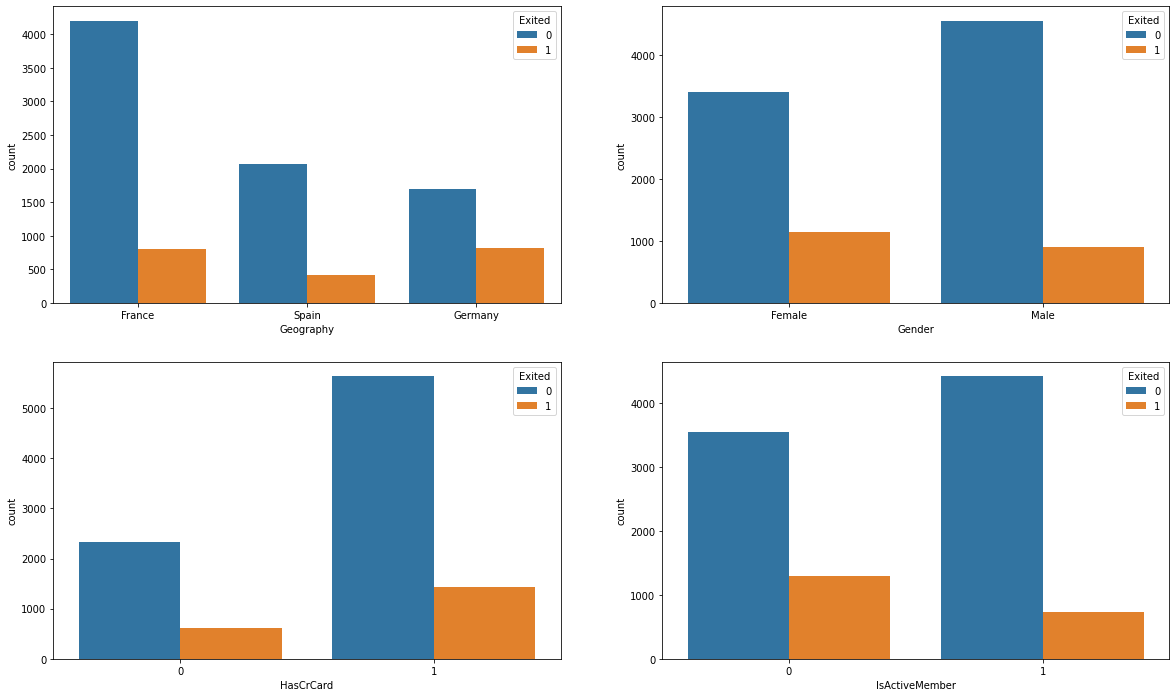

In [12]:
# We first review the 'Status' relation with categorical variables
fig, axarr = plt.subplots(2, 2, figsize=(20, 12))
sns.countplot(x='Geography', hue = 'Exited',data = df, ax=axarr[0][0])
sns.countplot(x='Gender', hue = 'Exited',data = df, ax=axarr[0][1])
sns.countplot(x='HasCrCard', hue = 'Exited',data = df, ax=axarr[1][0])
sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, ax=axarr[1][1])

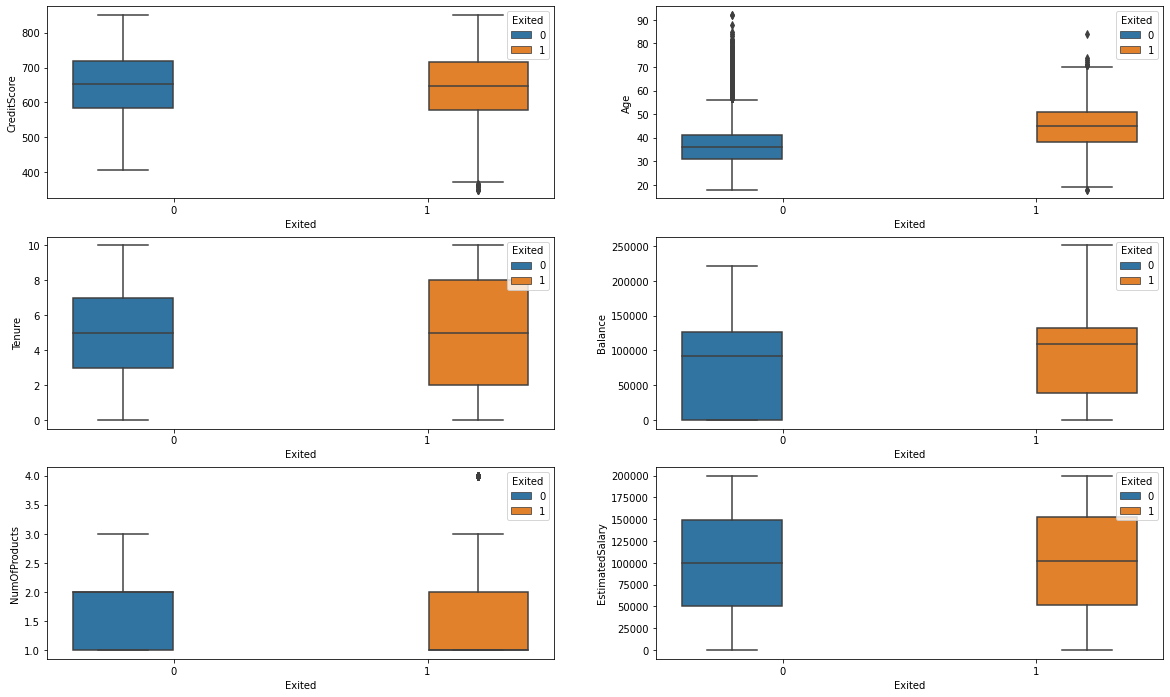

In [13]:
# Relations based on the continuous data attributes
fig, axarr = plt.subplots(3, 2, figsize=(20, 12))
sns.boxplot(y='CreditScore',x = 'Exited', hue = 'Exited',data = df, ax=axarr[0][0])
sns.boxplot(y='Age',x = 'Exited', hue = 'Exited',data = df , ax=axarr[0][1])
sns.boxplot(y='Tenure',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][0])
sns.boxplot(y='Balance',x = 'Exited', hue = 'Exited',data = df, ax=axarr[1][1])
sns.boxplot(y='NumOfProducts',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][0])
sns.boxplot(y='EstimatedSalary',x = 'Exited', hue = 'Exited',data = df, ax=axarr[2][1])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


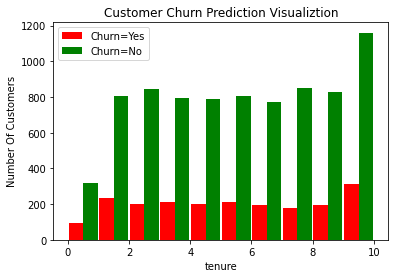

In [14]:
tenure_churn_no = df[df.Exited==0].Tenure
tenure_churn_yes = df[df.Exited==1].Tenure

plt.xlabel("tenure")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

plt.hist([tenure_churn_yes, tenure_churn_no], rwidth=0.95, color=['red','green'],label=['Churn=Yes','Churn=No'])
plt.legend()

## Feature Engineerig

Making a new column BalanceSalaryRatio

(-1.0, 5.0)

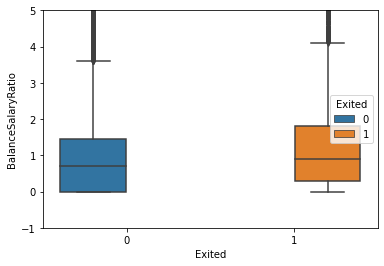

In [15]:
df['BalanceSalaryRatio'] = df.Balance/df.EstimatedSalary
sns.boxplot(y='BalanceSalaryRatio',x = 'Exited', hue = 'Exited',data = df)
plt.ylim(-1, 5)

Making a new column  TenureByAge

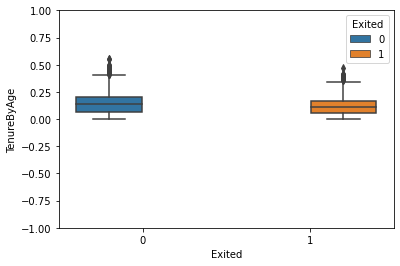

In [16]:
df['TenureByAge'] = df.Tenure/(df.Age)
sns.boxplot(y='TenureByAge',x = 'Exited', hue = 'Exited',data = df)
plt.ylim(-1, 1)
plt.show()

Printing the categorical variables

In [17]:
def print_unique_col_values(df):
       for column in df:
            if df[column].dtypes=='object':
                print(f'{column}: {df[column].unique()}')

In [18]:
print_unique_col_values(df)

Geography: ['France' 'Spain' 'Germany']
Gender: ['Female' 'Male']


###Label Encoding

In [19]:
df['Gender'].replace({'Male': 1,'Female': 0},inplace=True)

One Hot Encoding method

In [20]:
df1 = pd.get_dummies(data=df, columns=['Geography'])
df1.head(2)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,0.000000,0.047619,1,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0.744677,0.024390,0,0,1


In [21]:
scale_var = ['Tenure','CreditScore','Age','Balance','NumOfProducts','EstimatedSalary']

scaler = MinMaxScaler()
df1[scale_var] = scaler.fit_transform(df1[scale_var])

In [22]:
df1.head(2)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,Geography_France,Geography_Germany,Geography_Spain
0,0.538,0,0.324324,0.2,0.000000,0.0,1,1,0.506735,1,0.000000,0.047619,1,0,0
1,0.516,0,0.310811,0.1,0.334031,0.0,0,1,0.562709,0,0.744677,0.024390,0,0,1


In [23]:
X = df1.drop('Exited',axis='columns')  ##independent features
y = df1['Exited']  ##dependent feature

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)

In [24]:
len(X_train.columns)

14

##Model Building and Prediction

### The Sequential model

A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor

## A Sequential model is not appropriate when:

*   Your model has multiple inputs or multiple outputs
*   Any of your layers has multiple inputs or multiple outputs
*   You need to do layer sharing
*   You want non-linear topology (e.g. a residual connection, a multi-branch model)


In [27]:

model = keras.Sequential([
    keras.layers.Dense(12, input_shape=(None,32,14), activation='relu'),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])


model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=100)

Epoch 1/100
250/250 [==============================] - 1s 2ms/step - loss: 0.5380 - accuracy: 0.7815
Epoch 2/100
250/250 [==============================] - 0s 2ms/step - loss: 0.4882 - accuracy: 0.7944
Epoch 3/100
250/250 [==============================] - 0s 2ms/step - loss: 0.4733 - accuracy: 0.7971
Epoch 4/100
250/250 [==============================] - 0s 2ms/step - loss: 0.4753 - accuracy: 0.7964
Epoch 5/100
250/250 [==============================] - 0s 2ms/step - loss: 0.4960 - accuracy: 0.7905
Epoch 6/100
250/250 [==============================] - 0s 2ms/step - loss: 0.4415 - accuracy: 0.8055
Epoch 7/100
250/250 [==============================] - 0s 2ms/step - loss: 0.4541 - accuracy: 0.8106
Epoch 8/100
250/250 [==============================] - 0s 2ms/step - loss: 0.4263 - accuracy: 0.8188
Epoch 9/100
250/250 [==============================] - 0s 2ms/step - loss: 0.5040 - accuracy: 0.8152
Epoch 10/100
250/250 [==============================] - 0s 2ms/step - loss: 0.4370 - accura

In [28]:
model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 1ms/step - loss: 0.3627 - accuracy: 0.8535


[0.3626798093318939, 0.8535000085830688]

In [29]:
yp = model.predict(X_test)
yp

array([[0.03498793],
       [0.06683436],
       [0.04742539],
       ...,
       [0.02365309],
       [0.03348574],
       [0.04796645]], dtype=float32)

Converting our predictions to 0,1 to check accuracy

In [31]:
y_pred = []
for element in yp:
    if element > 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [34]:
y_pred[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

Checking the accuracy

In [35]:
from sklearn.metrics import confusion_matrix , classification_report

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1595
           1       0.77      0.40      0.52       405

    accuracy                           0.85      2000
   macro avg       0.82      0.68      0.72      2000
weighted avg       0.84      0.85      0.83      2000



Text(69.0, 0.5, 'Truth')

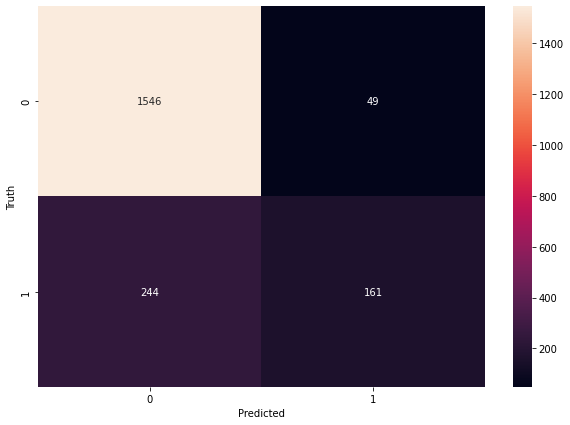

In [37]:
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred)

plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [39]:
print("Accuracy score is: ", accuracy_score(y_test,y_pred)*100,"%")

Accuracy score is:  85.35000000000001 %


#Using Auto ML

##H20 Auto ML

### H2O is a fully open-source, distributed in-memory machine learning platform with linear scalability. H2O supports the most widely used statistical & machine learning algorithms, including gradient boosted machines, generalized linear models, deep learning, and many more.

In [41]:
#Installing H2O Auto ML

!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future

In [42]:
!pip install h2o

     |████████████████████████████████| 175.8 MB 38 kB/s 
  Created wheel for h2o: filename=h2o-3.34.0.7-py2.py3-none-any.whl size=175908084 sha256=5b2e15b5a5690e9aa869dd9a651242ab1ec97c515cb63df121d96c5bec985b04
  Stored in directory: /root/.cache/pip/wheels/df/df/05/1f2ac68a5d9bf38b74f2b8218443b2c00f1a5f4f3154ec11b6
Successfully built h2o


In [43]:
import h2o
from h2o.automl import H2OAutoML
h2o.init(max_mem_size='16G')  ##  the h2o.init() makes sure that no prior instance of H2O is running.

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.13" 2021-10-19; OpenJDK Runtime Environment (build 11.0.13+8-Ubuntu-0ubuntu1.18.04); OpenJDK 64-Bit Server VM (build 11.0.13+8-Ubuntu-0ubuntu1.18.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpf2el2uwt
  JVM stdout: /tmp/tmpf2el2uwt/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpf2el2uwt/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.7
H2O_cluster_version_age:,29 days
H2O_cluster_name:,H2O_from_python_unknownUser_pgkzbz
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,16 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Loading the data

In [44]:
df = h2o.import_file("/content/Churn_Modelling.csv")

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [45]:
df.head(2)

RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
1,1.56346e+07,Hargrave,619,France,Female,42,2,0,1,1,1,101349,1
2,1.56473e+07,Hill,608,Spain,Female,41,1,83807.9,1,0,1,112543,0


H2O Auto ML can do all the data preprocessing techniques

Splitting the data

In [ ]:
df_train,df_test= df.split_frame(ratios=[.8])

In [47]:
df_train

RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
2,1.56473e+07,Hill,608,Spain,Female,41,1,83807.9,1,0,1,112543,0
4,1.57014e+07,Boni,699,France,Female,39,1,0,2,0,0,93826.6,0
5,1.57379e+07,Mitchell,850,Spain,Female,43,2,125511,1,1,1,79084.1,0
6,1.5574e+07,Chu,645,Spain,Male,44,8,113756,2,1,0,149757,1
7,1.55925e+07,Bartlett,822,France,Male,50,7,0,2,1,1,10062.8,0
8,1.56561e+07,Obinna,376,Germany,Female,29,4,115047,4,1,0,119347,1
9,1.57924e+07,He,501,France,Male,44,4,142051,2,0,1,74940.5,0
10,1.55924e+07,H?,684,France,Male,27,2,134604,1,1,1,71725.7,0
12,1.57372e+07,Andrews,497,Spain,Male,24,3,0,2,1,0,76390,0
13,1.56323e+07,Kay,476,France,Female,34,10,0,2,1,0,26261,0


In [48]:
y = "Exited"  ## dependent variable
x = df.columns  ## Independent variable
x.remove(y)
x.remove('CustomerId')
x.remove('RowNumber')
x.remove('Surname')

Defining the model

In [49]:
aml = H2OAutoML(max_runtime_secs=300,max_models = 10, seed = 10, verbosity="info", nfolds=2)

Fitting the model

In [50]:
aml.train(x=x,y=y, training_frame=df_train)

AutoML progress: |
16:39:35.551: Project: AutoML_1_20220119_163935
16:39:35.561: Setting stopping tolerance adaptively based on the training frame: 0.011154574690170912
16:39:35.562: Build control seed: 10
16:39:35.563: training frame: Frame key: AutoML_1_20220119_163935_training_py_3_sid_a27e    cols: 14    rows: 8037  chunks: 8    size: 426612  checksum: 7844131867108683167
16:39:35.565: validation frame: NULL
16:39:35.565: leaderboard frame: NULL
16:39:35.565: blending frame: NULL
16:39:35.566: response column: Exited
16:39:35.568: fold column: null
16:39:35.570: weights column: null
16:39:35.591: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (6g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w), def_3 (2g, 10w), def_4 (2g, 10w), def_1 (3g, 10w), grid_1 (4g, 60w), lr_annealing (6g, 10w)]}, {DeepLearning : [def_1 (3g, 10w), grid_1 (4g, 30w), grid

Seeing the Leaderboard

In [51]:
lb = aml.leaderboard

In [52]:
lb

model_id,mean_residual_deviance,rmse,mse,mae,rmsle
StackedEnsemble_AllModels_5_AutoML_1_20220119_163935,0.105197,0.324341,0.105197,0.214436,0.228159
StackedEnsemble_AllModels_2_AutoML_1_20220119_163935,0.105203,0.32435,0.105203,0.213268,0.228255
StackedEnsemble_AllModels_1_AutoML_1_20220119_163935,0.105229,0.32439,0.105229,0.213108,0.228289
StackedEnsemble_BestOfFamily_6_AutoML_1_20220119_163935,0.105814,0.32529,0.105814,0.21564,0.228794
StackedEnsemble_BestOfFamily_3_AutoML_1_20220119_163935,0.10591,0.325438,0.10591,0.214292,0.228963
StackedEnsemble_BestOfFamily_2_AutoML_1_20220119_163935,0.10609,0.325715,0.10609,0.214275,0.229084
GBM_2_AutoML_1_20220119_163935,0.106571,0.326452,0.106571,0.216957,0.229336
GBM_1_AutoML_1_20220119_163935,0.106884,0.326931,0.106884,0.220011,0.230099
StackedEnsemble_AllModels_4_AutoML_1_20220119_163935,0.106914,0.326977,0.106914,0.209576,0.228962
StackedEnsemble_BestOfFamily_1_AutoML_1_20220119_163935,0.106932,0.327005,0.106932,0.218862,0.230382


Getting all the model ids

In [53]:
model_ids = list(aml.leaderboard['model_id'].as_data_frame().iloc[:,0])

In [54]:
model_ids

['StackedEnsemble_AllModels_5_AutoML_1_20220119_163935',
 'StackedEnsemble_AllModels_2_AutoML_1_20220119_163935',
 'StackedEnsemble_AllModels_1_AutoML_1_20220119_163935',
 'StackedEnsemble_BestOfFamily_6_AutoML_1_20220119_163935',
 'StackedEnsemble_BestOfFamily_3_AutoML_1_20220119_163935',
 'StackedEnsemble_BestOfFamily_2_AutoML_1_20220119_163935',
 'GBM_2_AutoML_1_20220119_163935',
 'GBM_1_AutoML_1_20220119_163935',
 'StackedEnsemble_AllModels_4_AutoML_1_20220119_163935',
 'StackedEnsemble_BestOfFamily_1_AutoML_1_20220119_163935',
 'GBM_3_AutoML_1_20220119_163935',
 'DRF_1_AutoML_1_20220119_163935',
 'StackedEnsemble_BestOfFamily_5_AutoML_1_20220119_163935',
 'GBM_4_AutoML_1_20220119_163935',
 'XGBoost_3_AutoML_1_20220119_163935',
 'XRT_1_AutoML_1_20220119_163935',
 'StackedEnsemble_BestOfFamily_4_AutoML_1_20220119_163935',
 'StackedEnsemble_AllModels_3_AutoML_1_20220119_163935',
 'XGBoost_2_AutoML_1_20220119_163935',
 'XGBoost_1_AutoML_1_20220119_163935',
 'GLM_1_AutoML_1_20220119_16

In [55]:
aml.leader.model_performance(df_test)


ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.09310392993897637
RMSE: 0.3051293659072761
MAE: 0.1966205143866848
RMSLE: 0.21401412539012435
R^2: 0.43655270302165217
Mean Residual Deviance: 0.09310392993897637
Null degrees of freedom: 1962
Residual degrees of freedom: 1955
Null deviance: 324.4468071792313
Residual deviance: 182.7630144702106
AIC: 928.5143529117948


Getting the model details for best performing model

In [56]:
h2o.get_model([mid for mid in model_ids if "StackedEnsemble" in mid][0])

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_5_AutoML_1_20220119_163935

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.06641812274763603
RMSE: 0.2577171370856739
MAE: 0.16633450009320777
RMSLE: 0.1781479628159806
R^2: 0.588633472502788
Mean Residual Deviance: 0.06641812274763603
Null degrees of freedom: 8036
Residual degrees of freedom: 8029
Null deviance: 1297.6322010700696
Residual deviance: 533.8024525227507
AIC: 1031.399311297823

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.105197218943922
RMSE: 0.32434120759459784
MAE: 0.21443560718413007
RMSLE: 0.22815897604942315
R^2: 0.3484517046085083
Mean Residual Deviance: 0.105197218943922
Null degrees of freedom: 8036
Residual degrees of freedom: 8029
Null deviance: 1298.3627271427736
Residual deviance: 845.4700486523011
AIC: 4727.349682001869


In [57]:
output= h2o.get_model([mid for mid in model_ids if "StackedEnsemble" in mid][0])
output.params

{'auc_type': {'actual': 'AUTO', 'default': 'AUTO', 'input': 'AUTO'},
 'base_models': {'actual': [{'URL': None,
    '__meta': {'schema_name': 'KeyV3',
     'schema_type': 'Key<Keyed>',
     'schema_version': 3},
    'name': 'GBM_2_AutoML_1_20220119_163935',
    'type': 'Key<Keyed>'},
   {'URL': None,
    '__meta': {'schema_name': 'KeyV3',
     'schema_type': 'Key<Keyed>',
     'schema_version': 3},
    'name': 'GBM_1_AutoML_1_20220119_163935',
    'type': 'Key<Keyed>'},
   {'URL': None,
    '__meta': {'schema_name': 'KeyV3',
     'schema_type': 'Key<Keyed>',
     'schema_version': 3},
    'name': 'GBM_3_AutoML_1_20220119_163935',
    'type': 'Key<Keyed>'},
   {'URL': None,
    '__meta': {'schema_name': 'KeyV3',
     'schema_type': 'Key<Keyed>',
     'schema_version': 3},
    'name': 'DRF_1_AutoML_1_20220119_163935',
    'type': 'Key<Keyed>'},
   {'URL': None,
    '__meta': {'schema_name': 'KeyV3',
     'schema_type': 'Key<Keyed>',
     'schema_version': 3},
    'name': 'GBM_4_AutoML_1_2

In [58]:
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_5_AutoML_1_20220119_163935

No model summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.06641812274763603
RMSE: 0.2577171370856739
MAE: 0.16633450009320777
RMSLE: 0.1781479628159806
R^2: 0.588633472502788
Mean Residual Deviance: 0.06641812274763603
Null degrees of freedom: 8036
Residual degrees of freedom: 8029
Null deviance: 1297.6322010700696
Residual deviance: 533.8024525227507
AIC: 1031.399311297823

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.105197218943922
RMSE: 0.32434120759459784
MAE: 0.21443560718413007
RMSLE: 0.22815897604942315
R^2: 0.3484517046085083
Mean Residual Deviance: 0.105197218943922
Null degrees of freedom: 8036
Residual degrees of freedom: 8029
Null deviance: 1298.3627271427736
Residual deviance: 845.4700486523011
AIC: 4727.349682001869


In [59]:
y_pred=aml.leader.predict(df_test)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [60]:
y_pred

predict
0.235844
0.977429
0.0295842
1.00622
0.197444
0.0348027
0.14815
0.0838831
0.685477
0.248511
